<a href="https://colab.research.google.com/github/gibi177/NOIA/blob/main/Reconhecimento_de_digital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de digital

## Trabalho final da disciplina Noções de Inteligência Artificial - 2/2024
## Alunos: Felipe Lopes Gibin Duarte (231025207) e Matheus das Neves Fernandes (231013672)


## Introdução

O reconhecimento de digitais é uma tecnologia essencial no mundo contemporâneo, sendo amplamente utilizada em aplicações como o desbloqueio de dispositivos móveis e o controle de acesso a informações confidenciais. Neste trabalho, resolveremos o problema de reconhecimento de digitais desenvolvendo uma rede neural capaz de distinguir digitais reais de falsificadas, utilizando o dataset FVC2000 DB4. Para isso, será aplicada a técnica do transfer learning com a arquitetura da ResNet50. Visamos demonstrar a versatilidade e aplicabilidade de redes neurais na tarefa de reconhecimento de imagens.

## 1. Preparação do ambiente

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: felipegibin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b


100%|██████████| 25.9M/25.9M [00:00<00:00, 156MB/s] 

In [11]:
# Path to dataset folder
dataset_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data"

# Dictionary to store the count of fingerprints per person
person_fingerprints = defaultdict(int)

# Iterate over files
for filename in os.listdir(dataset_path):
    if filename.endswith(".bmp"):
        person_id = filename.split("_")[0]  # Extract the person ID
        person_fingerprints[person_id] += 1

# Total number of unique persons
num_persons = len(person_fingerprints)

print(f"Total number of persons: {num_persons}")
print("Number of fingerprints per person:")
for person_id, count in person_fingerprints.items():
    print(f"Person {person_id}: {count} fingerprints")

Total number of persons: 10
Number of fingerprints per person:
Person 00002: 80 fingerprints
Person 00009: 80 fingerprints
Person 00003: 80 fingerprints
Person 00001: 80 fingerprints
Person 00004: 80 fingerprints
Person 00008: 80 fingerprints
Person 00006: 80 fingerprints
Person 00005: 80 fingerprints
Person 00000: 80 fingerprints
Person 00007: 80 fingerprints


Caminhos das primeiras 3 digitais:
['/content/split_dataset/train/00000/00000_55.bmp', '/content/split_dataset/train/00000/00000_26.bmp', '/content/split_dataset/train/00000/00000_37.bmp']


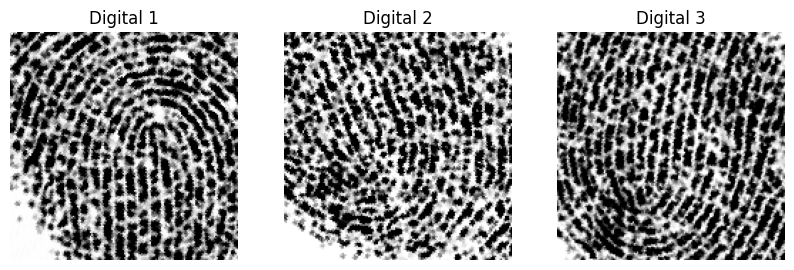

In [17]:
# Caminho para as digitais da pessoa com id 00000
person_0_path = "/content/split_dataset/train/00000"

# Listar todas as imagens no diretório
person_0_digitals = [os.path.join(person_0_path, img) for img in os.listdir(person_0_path) if img.endswith(".bmp")]

# Exibir os caminhos das primeiras 3 digitais da pessoa 0
print("Caminhos das primeiras 3 digitais:")
print(person_0_digitals[:3])

# Função para exibir as imagens
def show_images(image_paths, num_images=3):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = image.load_img(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Digital {i + 1}")
        plt.axis('off')
    plt.show()

# Exibir as primeiras 3 digitais
show_images(person_0_digitals, num_images=3)

In [15]:
# Separa o dataset em dados de treinamento e teste

import os
import shutil
from sklearn.model_selection import train_test_split

# Definir caminhos
base_dir = '/content/split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Criar diretórios
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Coletar caminhos de arquivos e labels
file_paths = []
labels = []

for filename in os.listdir(dataset_path):
    if filename.endswith(".bmp"):
        person_id = filename.split("_")[0]
        file_paths.append(os.path.join(dataset_path, filename))
        labels.append(person_id)

# Split estratificado (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Função para copiar arquivos para diretórios estruturados
def copy_files(file_paths, labels, target_dir):
    for file_path, person_id in zip(file_paths, labels):
        dest_dir = os.path.join(target_dir, person_id)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(file_path, dest_dir)

# Copiar arquivos
copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)

print(f"Treino: {len(X_train)} imagens")
print(f"Validação: {len(X_val)} imagens")

Divisão concluída!
Treino: 640 imagens
Validação: 160 imagens
